## TF-IDF

This notebook prepares the TFIDF and PCA data.

In [1]:
import pandas as pd
import numpy as np
import json

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.linalg import norm

# local library
from preproc import *

In [2]:
sw = set(stopwords.words('english') + ["[applause]", "[music]"] \
    + ["that's", "they'll", "they're", "we'll", "we're", "i'm", "i'll", "they've",
 "i've", "here's", "it'll", "we've", "let's", "he's", "there's", "i'd", "what's"])

In [3]:
# load the latest data, put into a standard format
with open('speeches.json') as f:
    speeches = json.load(f)
    
bow = create_bow(speeches)

In [4]:
import string
import re
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer

def my_tokenizer(document):
        #tk = WhitespaceTokenizer()
        stemmer = SnowballStemmer("english")
        # Break the sentence into tokens based on whitespace
        for token in document.split():
            # Apply preprocessing to the token
            token = token.lower().strip()
            token = re.sub(r'[_*:!?& ]', '', token).rstrip('.,')

            # If punctuation, ignore token and continue
            if all(char in set(string.punctuation) for char in token):
                continue
                
            # if empty str, continue
            if token == '':
                continue
                
            # skip stopwords
            if token in sw:
                continue

            # stem the token and yield
            stem = stemmer.stem(token)
            yield token

## n-grams

In [5]:
# Create counts and tfidf matrices (at the speech level)
vectorizer = CountVectorizer(max_features=5000, # only top 5k words
                             min_df=2,          # words must appear in this many speeches to count
                             #max_df=0.9,        # words can't appear in more % of speeches than this.  
                             stop_words=stopwords.words('english'),
                             tokenizer=my_tokenizer,
                             ngram_range=(1,1)  # (1,3) combined unigrams, bigrams, trigrams
                            )

counts = vectorizer.fit_transform(bow['speech'])

counts_df = pd.DataFrame(counts.toarray())
counts_df.index.name = 'speech'
#tfidf.columns = tfidf.apply(lambda x: vocab_r[x.name])
counts_df.columns = vectorizer.get_feature_names()

counts_df['videoId'] = bow.index.values
counts_df = counts_df.set_index('videoId')
counts_df['_speaker'] = counts_df.apply(lambda x: bow.loc[x.name].speaker, 1)
counts_df = counts_df.reset_index().set_index(['_speaker'])

# convert counts into tfidf
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(counts)
# tidy up
tfidf_df = pd.DataFrame(tfidf.toarray())
tfidf_df.index.name = 'speech'
tfidf_df.columns = vectorizer.get_feature_names()
tfidf_df['videoId'] = bow.index.values
tfidf_df = tfidf_df.set_index('videoId')
tfidf_df['_speaker'] = tfidf_df.apply(lambda x: bow.loc[x.name].speaker, 1)
tfidf_df = tfidf_df.reset_index().set_index(['videoId','_speaker'])


In [6]:
# TFIDF at the speaker level
# convert counts into tfidf
transformer = TfidfTransformer(smooth_idf=True)
tfidf_speaker2 = transformer.fit_transform(counts_df.sum(level='_speaker'))
tfidf_speaker2 = pd.DataFrame(tfidf_speaker2.toarray())
tfidf_speaker2.columns = vectorizer.get_feature_names()
tfidf_speaker2['_speaker'] = counts_df.sum(level='_speaker').index.values
tfidf_speaker2 = tfidf_speaker2.set_index('_speaker')
tfidf_speaker2.index.name = 'speaker'
# Normalize doc vector lengths - this is done by the Transformer
#tfidf_speaker2 = tfidf_speaker2.apply(lambda x: x / norm(x), 1)
# transpose for easier filtering
tfidf_speaker2 = tfidf_speaker2.T.reset_index()

In [7]:
# Save files for display
tfidf_df.to_csv('data/tfidf.csv')
tfidf_speaker2.to_csv('data/tfidf_speaker.csv')

## HCA - dendrogram

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

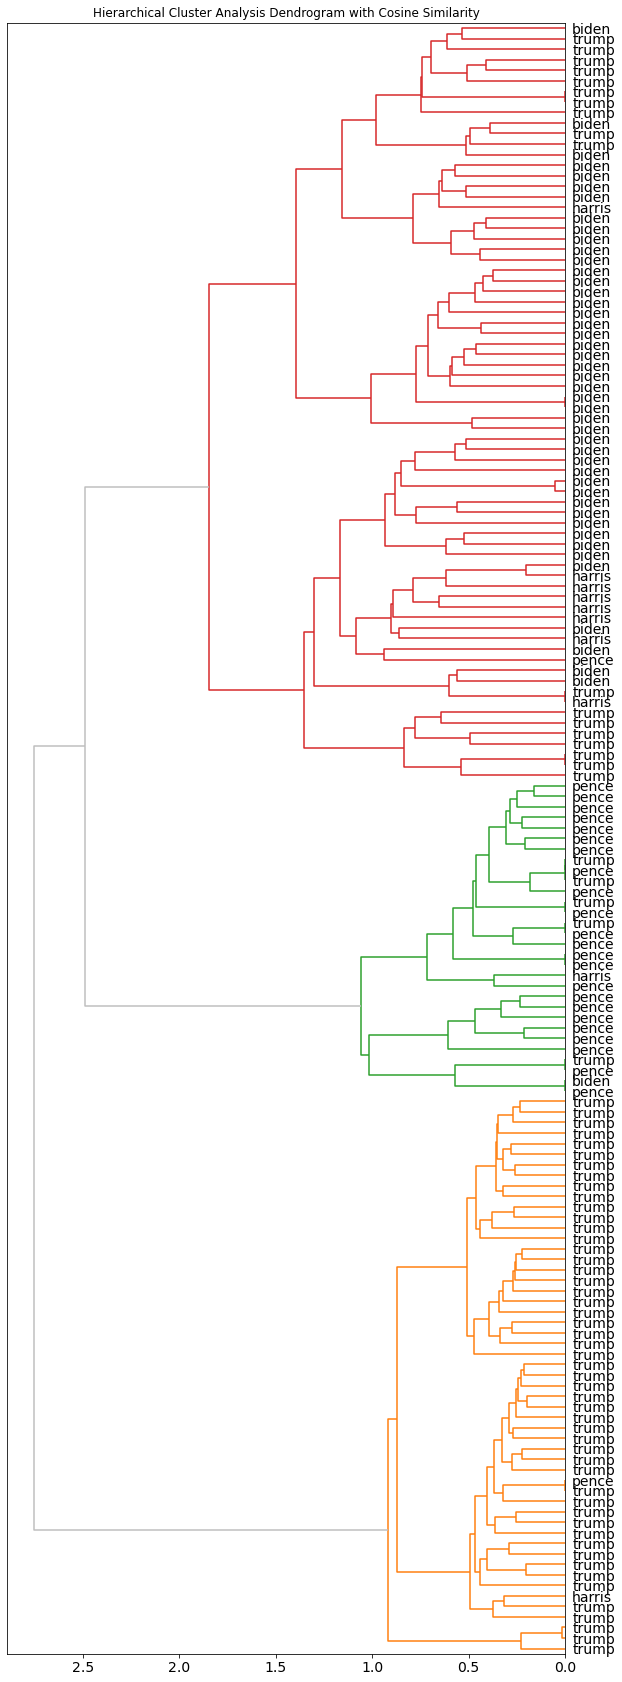

In [8]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 30)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = bow.speaker.values 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    
all_sp = tfidf_df
L1 = all_sp.apply(lambda x: x / x.sum(), 1)

PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([bow.index.tolist(), bow.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['speech_a', 'speech_b']

PAIRS['cosine'] = pdist(L1, 'cosine')

# save speech groups for later
tree = sch.linkage(PAIRS['cosine'], method='ward')
cuts = sch.cut_tree(tree, height=2)
bow['group'] = cuts
bow['date'] = pd.to_datetime(bow['date'])

# print/save dendrogram
fig=plt.figure()
hca(PAIRS['cosine'], color_thresh=2)
plt.title('Hierarchical Cluster Analysis Dendrogram with Cosine Similarity')
fig.tight_layout()
plt.savefig('data/dendrogram.png', bbox_inches='tight')

## Principal Components Analysis

In [9]:
from sklearn.decomposition import PCA
from scipy.linalg import norm

# normalize vectors
tfidf_df = tfidf_df.apply(lambda x: x / norm(x), 1)
# center vectors
tfidf_df = tfidf_df - tfidf_df.mean()

pca = PCA(n_components=4)
pca.fit(tfidf_df)

## Loadings
# term loadings = eigenvectors * eigenvalues
loadings = pd.DataFrame(pca.components_).T * np.sqrt(pca.explained_variance_)
loadings['trump_rally'] = (loadings[0]+loadings[1])*-1
loadings['pence'] = loadings[0]+(loadings[1]*-1)
loadings['interviews'] = loadings[1]+(loadings[0]*-1)
loadings['formal'] = loadings[0]+loadings[1]

# put term strings back as index
loadings.index = [tfidf_df.T.index[i] for i in loadings.index.values]
loadings.index.name = 'term'

## DCM - doc-component matrix
dcm = pd.DataFrame(pca.transform(tfidf_df))
dcm.index = [tfidf_df.index[i][0] for i in dcm.index.values]
# copy in useful descriptions
dcm.index.name = "id"
dcm['title'] = dcm.apply(lambda x: bow.loc[x.name].title, 1)
dcm['speaker'] = dcm.apply(lambda x: bow.loc[x.name].speaker, 1)
dcm['group'] = dcm.apply(lambda x: bow.loc[x.name].group, 1)
dcm['date'] = dcm.apply(lambda x: bow.loc[x.name].date, 1)

In [10]:
# Save the PCA plots to files
import plotly_express as px
import plotly.io as pio

fig = px.scatter(dcm, 0, 1, 
                    color='speaker', 
                    hover_name='title')
pio.write_html(fig, file='data/pca1.html')

fig2 = px.scatter(dcm, 0, 1, 
                    color='group', 
                    hover_name='title')
pio.write_html(fig2, file='data/pca1_groups.html')

In [11]:
dcm.to_csv('data/dcm.csv')
loadings.to_csv('data/loadings.csv')